# **Atmospheric Temperature and Precipitation in Dubai from 1995 to 2024**

# Urban Evolution of Dubai - A Comparative Remote Sensing Analysis from 1995 to 2024

**Erik Ashkinadze (erik.ashkinadze@ruhr-uni-bochum.de)**

**Devon Klör (devon.kloer@ruhr-uni-bochum.de)**

**Course:** Geographic Information Systems (GIS I): Databases and Programming

**Professor:** Jun.-Prof. Dr. Andreas Rienow

**References:** Tran, L. (2024): Analyzing CHIRPS rainfall data using Google Earth Engine https://medium.com/@linhha53/analyzing-chirps-rainfall-data-using-google-earth-engine-bb4901ca29b7


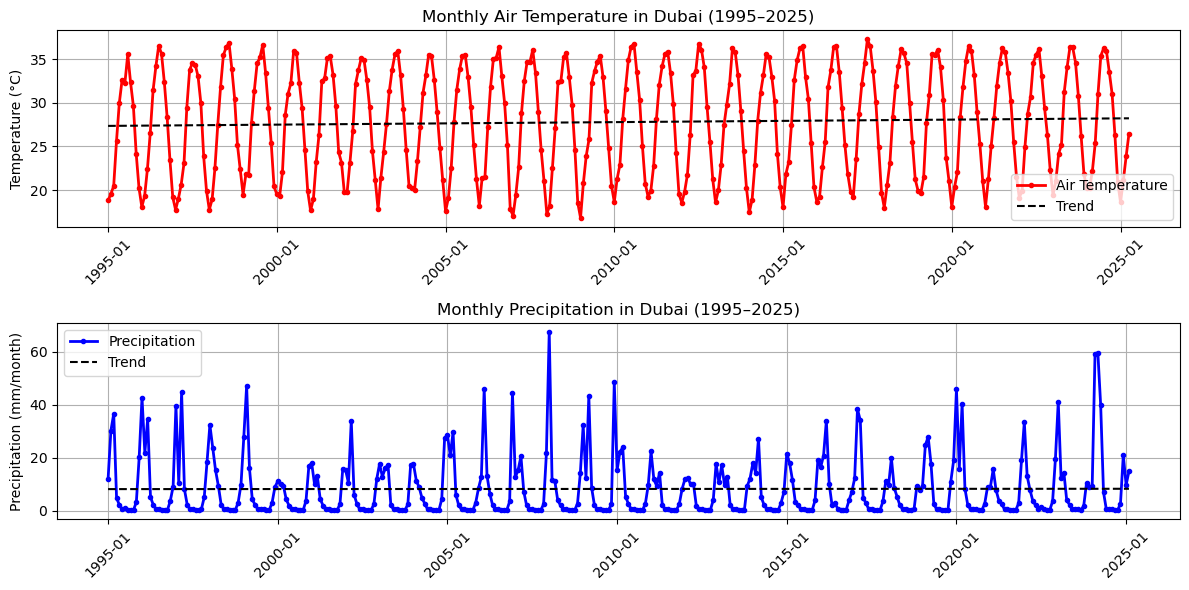

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-dkloer01')

# import Dubai Shapefile
shapefile_path = "./Dubai_Shapes/Dubai.shp"
dubai = geemap.shp_to_ee(shapefile_path)

# ============================================
# Monthly Temperature Calculation (1995–2025)
# ============================================

# Function to calculate monthly mean air temperature from ERA5-Land Daily Aggregated dataset
def get_monthly_temperature():
    # Load image collection and filter by date and region
    collection = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")\
        .filterBounds(dubai)\
        .filterDate("1995-01-01", "2025-12-31")\
        .select("temperature_2m")

    monthly_temp = []
    dates_temp = []

    # Loop through each year and month in the defined time range
    # Set the month range to 28 days to avoid issues with different months
    for year in range(1995, 2026):
        for month in range(1, 13):
            start = f"{year}-{month:02d}-01"
            end = f"{year}-{month:02d}-28"

            # Calculate mean temperature for the month and reduce to region mean
            image = collection.filterDate(start, end).mean().reduceRegion(
                reducer=ee.Reducer.mean(), geometry=dubai, scale=5000
            ).getInfo()

            # If valid data exists, convert from Kelvin to Celsius and store values
            if image and "temperature_2m" in image:
                monthly_temp.append(image["temperature_2m"] - 273.15)
                dates_temp.append(f"{year}-{month:02d}")

    return dates_temp, monthly_temp

# Call function to retrieve temperature data
temp_dates, temp_data = get_monthly_temperature()

# ============================================
# Monthly Precipitation Calculation (1995–2025)
# ============================================
# Function to get total monthly precipitation (summed from 5-day CHIRPS data)
def get_monthly_precipitation():
    # Load CHIRPS Pentad (5-day) precipitation dataset
    collection = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterBounds(dubai) \
        .filterDate("1995-01-01", "2025-12-31")

    monthly_precip = []
    dates_precip = []

    # Loop through each year and month in the defined time range
    # Set the month range to 28 days to avoid issues with different months
    for year in range(1995, 2026):
        for month in range(1, 13):
            start = f"{year}-{month:02d}-01"
            end = f"{year}-{month:02d}-28"

            # Use .sum() and not .mean() to sum up all 5-day precipitation images for each month
            image = collection.filterDate(start, end).sum().reduceRegion(
                reducer=ee.Reducer.mean(), geometry=dubai, scale=5000
            ).getInfo()

            # Store values if they exist
            if image and "precipitation" in image:
                monthly_precip.append(image["precipitation"])
                dates_precip.append(f"{year}-{month:02d}")

    return dates_precip, monthly_precip

# Call function to retrieve precipitation data
precip_dates, precip_data = get_monthly_precipitation()

# ============================================
# Plot Temperature and Precipitation with Trends
# ============================================

plt.figure(figsize=(12, 6))

# -------- Temperature Plot --------
plt.subplot(2, 1, 1)
plt.plot(temp_dates, temp_data, color="red", label="Air Temperature", linewidth=2, marker="o", markersize=3)

# Calculate linear trend line for temperature
x_temp = np.arange(len(temp_data))
y_temp = np.array(temp_data)
z_temp = np.polyfit(x_temp, y_temp, 1)
p_temp = np.poly1d(z_temp)
plt.plot(temp_dates, p_temp(x_temp), color="black", linestyle="--", label="Trend")

# X-axis formatting
plt.xticks(
    np.arange(0, len(temp_dates), 60),
    [temp_dates[i] for i in range(0, len(temp_dates), 60)],
    rotation=45
)
plt.ylabel("Temperature (°C)")
plt.title("Monthly Air Temperature in Dubai (1995–2025)")
plt.grid()
plt.legend()

# -------- Precipitation Plot --------
plt.subplot(2, 1, 2)
plt.plot(precip_dates, precip_data, color="blue", label="Precipitation", linewidth=2, marker="o", markersize=3)

# Calculate linear trend line for precipitation
x_precip = np.arange(len(precip_data))
y_precip = np.array(precip_data)
z_precip = np.polyfit(x_precip, y_precip, 1)
p_precip = np.poly1d(z_precip)
plt.plot(precip_dates, p_precip(x_precip), color="black", linestyle="--", label="Trend")

# X-axis formatting
plt.xticks(
    np.arange(0, len(precip_dates), 60),
    [precip_dates[i] for i in range(0, len(precip_dates), 60)],
    rotation=45
)
plt.ylabel("Precipitation (mm/month)")
plt.title("Monthly Precipitation in Dubai (1995–2025)")
plt.grid()
plt.legend()

# Adjust subplot layout
plt.tight_layout()
plt.show()
